<a href="https://colab.research.google.com/github/pythonuzgit/Computer-vision-in-Medical-imaging/blob/main/Computer-vision-in-Medical-imaging%20/Brain_MRI_Scan_images_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!kaggle datasets download -d volodymyrpivoshenko/brain-mri-scan-images-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
License(s): CC0-1.0
  0% 0.00/6.65M [00:00<?, ?B/s]
100% 6.65M/6.65M [00:00<00:00, 95.9MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.utils import shuffle
from PIL import Image
from glob import glob


In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")

else:
  device = torch.device("cpu")

Custom Data Generator

In [7]:
class BrainMRIDataset(Dataset):

  def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder =False):

    self.dataDirectory = data_dir
    self.no_class = glob(data_dir+'/negative/*') # Fixed the typo here
    self.yes_class = glob(data_dir+'/positive/*')

    self.height = height
    self.width = width
    self.reshape = reshape
    self.autoencoder = autoencoder

    labels = [0 for i in range(len(self.no_class))] # Fixed the typo here
    labels += [1 for i in range(len(self.yes_class))]

    image_links = self.no_class + self.yes_class # Fixed the typo here

    self.dataframe = pd.DataFrame({"image":image_links, "labels":labels})
    self.dataframe.reset_index(inplace = True ,drop=True)

  def __len__(self):
    return len(self.no_class)+len(self.yes_class) # Fixed the typo here

  def __getitem__(self,idx):

    image_list = self.dataframe["image"][idx]
    label_list = self.dataframe["labels"][idx]

    if type(image_list) == str:
      image_list = [image_list]

    if not isinstance(label_list,np.int64):
      label_list = label_list.values

    image_array = []

    for image in image_list:
      image = Image.open(image).convert("L")

      if self.reshape:
        image = image.resize((self.height,self.width))

      array = np.asarray(image)

      array = array.reshape(1,self.height,self.width)

      image_array.append(array)



    return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]



  def __repr__(self):
    return str(self.dataframe.head(10))

In [8]:
dataset = BrainMRIDataset("/content/brain_mri_scan_images")

In [9]:
print(dataset)

                                            image  labels
0  /content/brain_mri_scan_images/negative/76.jpg       0
1  /content/brain_mri_scan_images/negative/62.jpg       0
2  /content/brain_mri_scan_images/negative/83.jpg       0
3  /content/brain_mri_scan_images/negative/26.jpg       0
4  /content/brain_mri_scan_images/negative/69.jpg       0
5  /content/brain_mri_scan_images/negative/34.jpg       0
6  /content/brain_mri_scan_images/negative/81.jpg       0
7  /content/brain_mri_scan_images/negative/16.jpg       0
8  /content/brain_mri_scan_images/negative/75.jpg       0
9   /content/brain_mri_scan_images/negative/4.jpg       0


Custom CNN Model

In [10]:
class BrainTumorModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,256,kernel_size=3), #126*126*256
        nn.MaxPool2d(2,2), # 63*63*256

        nn.Conv2d(256,32,kernel_size=2) #63-2+1 = 62*62*32
    )

    # n-f+2p/s +1

    self.linear1 = nn.Linear(62,128)
    self.linear2 = nn.Linear(128,64)
    self.flat = nn.Flatten(1)
    self.linear3 = nn.Linear(126976,2)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    x = self.flat(x)
    x = self.linear3(x)

    return x

In [11]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [13]:
epochs =100
batch_size = 32
loss_list = []

for epoch in range(epochs):
  total_loss = 0.0

  for n in range(len(dataset)//batch_size):

    data , target = dataset[n*batch_size : (n+1)*batch_size]

    ypred = model.forward(data.float())
    loss = loss_fn(ypred,target)

    total_loss+=loss

    optimizer.zero_grad() #clear the gradients
    loss.backward() # calculate the gradeint
    optimizer.step() # Wn = Wo - lr* gradeint

  loss_list.append(total_loss/batch_size)

  print("Epochs {}  Training Loss {:.2f}".format(epoch+1,total_loss/n))


<ipython-input-7-1c1ed08c668e>:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]


Epochs 1  Training Loss 523.75
Epochs 2  Training Loss 12.74
Epochs 3  Training Loss 1.67
Epochs 4  Training Loss 1.23
Epochs 5  Training Loss 1.54
Epochs 6  Training Loss 1.14
Epochs 7  Training Loss 1.40
Epochs 8  Training Loss 1.19
Epochs 9  Training Loss 1.32
Epochs 10  Training Loss 1.21
Epochs 11  Training Loss 1.28
Epochs 12  Training Loss 1.23
Epochs 13  Training Loss 1.25
Epochs 14  Training Loss 1.22
Epochs 15  Training Loss 1.23
Epochs 16  Training Loss 1.20
Epochs 17  Training Loss 1.20
Epochs 18  Training Loss 1.18
Epochs 19  Training Loss 1.18
Epochs 20  Training Loss 1.16
Epochs 21  Training Loss 1.15
Epochs 22  Training Loss 1.14
Epochs 23  Training Loss 1.19
Epochs 24  Training Loss 1.09
Epochs 25  Training Loss 1.13
Epochs 26  Training Loss 1.08
Epochs 27  Training Loss 1.10
Epochs 28  Training Loss 1.07
Epochs 29  Training Loss 1.08
Epochs 30  Training Loss 1.07
Epochs 31  Training Loss 1.06
Epochs 32  Training Loss 1.05
Epochs 33  Training Loss 1.05
Epochs 34  Train

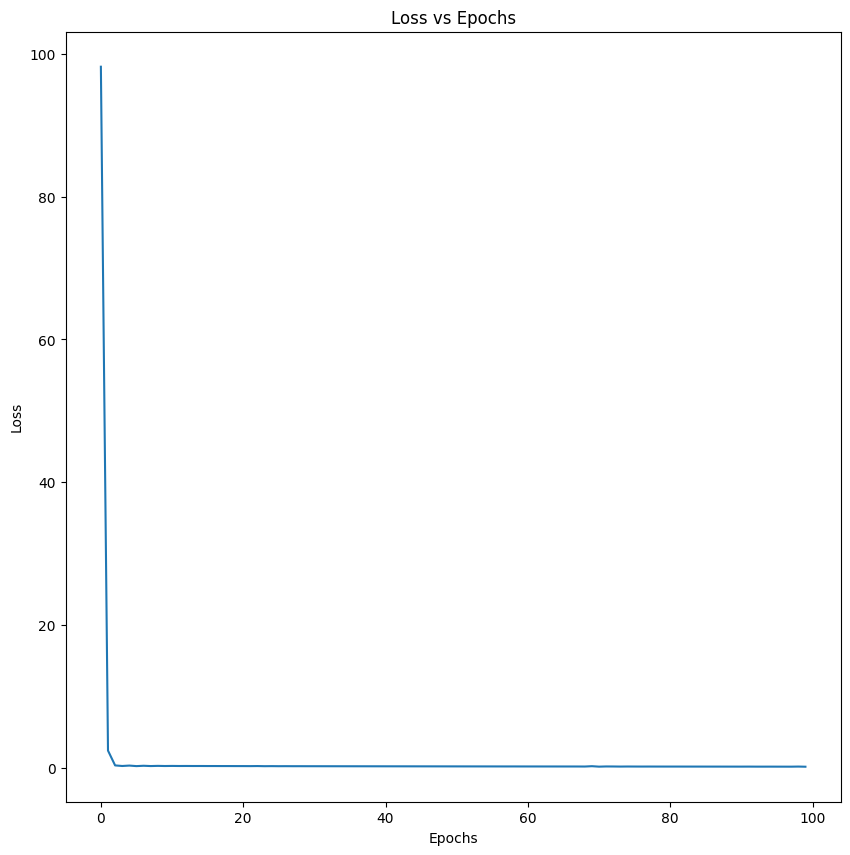

In [14]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)), [loss.detach().numpy() for loss in loss_list]) # Convert the list of tensors to a list of numpy arrays
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

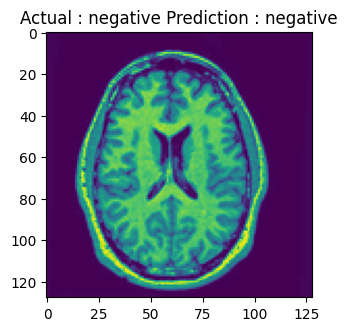

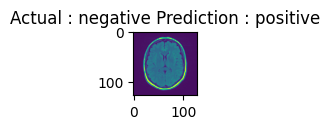

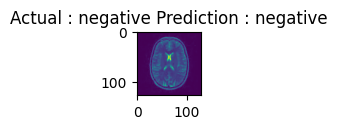

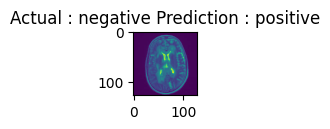

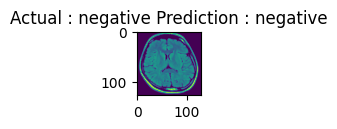

In [16]:
mapping = {0:"negative",1:"positive"}
fig = plt.figure(figsize=(20,20))

for i in range(5):
  data,target = dataset[i]
  pred = model.forward(data.float())

  pred = torch.argmax(pred,dim=1)
  plt.subplot(5,5,i+1)
  plt.imshow(data[0][0].cpu())
  plt.title(f"Actual : {mapping[target.cpu().detach().item()]} Prediction : {mapping[pred.cpu().detach().item()]}")
  plt.show()